In [ ]:
!pip install nose

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
import pickle
from urllib.request import urlopen

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
np.random.RandomState(42)

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import seaborn as sns

#import unittest
from nose.tools import *

import time

import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm, skew, kurtosis

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV,cross_val_score 
from sklearn import preprocessing
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_log_error,mean_squared_error, make_scorer


# London Bike sharing demand predicton
## Machine learning algorithms for prediction of bike sharing demand in London.


## Author: Hristo Mavrodiev
Project requirements - [link](https://softuni.bg/downloads/svn/Data-Science/June-2019/09.%20Exam/assessment-guidelines.txt)



![alt text](https://imgs.xkcd.com/comics/timeline_of_bicycle_design.png)
   
   XKCD.com


## Abstract:
The purpose of this research is to try a machine learning approach for predicting bike sharing demand in London by given the hour, day, and information about the weather. The research contains: Data exploration, feature engineering, choosing appropriate scoring metric, cross algorithms, cross validation, tuning the algorithms,analysis of feature importance, analysis of residuals and performance evaluation. The used dataset is from years 2015 and 2016. With XGBoost the lowest RMSLE achieved on test set is 0.2611. With Random Forest lowest RMSLE is 0.2807.





## Introduction:
The bike sharing is one of the methods of reducing city traffic. It is also lowering the air pollution by reducing the number of cars on the roads. The hypothesis in the research is that the bike sharing are highly related with the time of the day, season and weather conditions. The research will try to predict the bike shares in the future. The predictions of future use could help for a better management of the service. Another point of view is to test the machine learning algorithms how good are at solving this problem.

## The  Datasets description
The following code shows the loading of the bike sharing dataset. The data is gathered from 3 sources:  
 * https://cycling.data.tfl.gov.uk/ *'Contains OS data © Crown copyright and database rights 2016' and Geomni UK Map data © and database rights [2019] 'Powered by TfL Open Data'* - Bike sharing usage dataset
 * https://freemeteo.com - weather data
 * https://www.gov.uk/bank-holidays - official bank holidays in London.
 
 
After the data is grouped by hour and merged is published on "Kaggle" - 
https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset [1]  
*Note*: The official data for bike sharing contains "Start date" and "End Date" columns, for the calculations the trips are grouped by "Start date" column for every hour.So if the sharing is the long duration and passes 1 hour it's not  counted again.


## 1.Data Analysis and exploration

### Metadata:
"timestamp" - *timestamp field for grouping the data*  
"cnt" - *the count of a new bike shares*  
"t1" - *real temperature in C*  
"t2" - *temperature in C "feels like"*  
"hum" - *humidity in percentage*  
"wind_speed" - *wind speed in km/h*  
"weather_code" - *category of the weather*  
"is_holiday" - *boolean field - 1 holiday / 0 non holiday*  
"is_weekend" - *boolean field - 1 if the day is weekend*   
"season" - *category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.*  

       
       
  


"weathe_code" category description:  
*1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity  
2 = scattered clouds / few clouds  
3 = Broken clouds  
4 = Cloudy  
7 = Rain/ light Rain shower/ Light rain  
10 = rain with thunderstorm  
26 = snowfall  
94 = Freezing Fog*

In [ ]:
london= pd.read_csv('https://www.dropbox.com/s/z0twef3ygv8budm/london_merged.csv?dl=1')
assert_is_not_none(london)
assert_is_instance(london, pd.DataFrame)
assert_equal(london.shape, (17414,10))
london.head()

In [ ]:
london.dtypes

In [ ]:
london.describe()

In [ ]:
london.info()

In [0]:
london['timestamp'] = pd.to_datetime(london['timestamp'], format ="%Y-%m-%d %H:%M:%S")

In [ ]:
london['weather_code'].unique()
#1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity
#2 = scattered clouds / few clouds
#3 = Broken clouds
#4 = Cloudly
#7 = Rain/ light Rain shower/ Light rain
#10 = rain with thunderstorm
#26 = snowfall
#94 = Freezing Fog


In [0]:
weather_dict = {1 : 100,  2 : 100,  3 : 100,  4 : 100, 
                7 : 200, 10 : 200, 26 : 200, 94 : 200}
london['weather_code']=london['weather_code'].replace(weather_dict)

In [0]:
london['count_log'] = np.log1p(london['cnt'])

In [ ]:
def plot_distribution(london,columns,**kwargs ):
    """
    Function to plot a dataframe feature distribution.
    Input: 
    df - pandas DataFrame.
    columns - list of the df columns that should be plotted
    Output: multiple feature histograms
    
    Note: String columns should be dropped before passing to the function.
    """
    assert_is_not_none(london)
    assert_is_instance(london, pd.DataFrame)
    
    fig, axes = plt.subplots(ncols=len(columns),figsize=(30,5))
    for axs, col in zip(axes, columns):
        sns.distplot(london[col], ax=axs,**kwargs)
    fig.suptitle('Feature distribution')
    
plot_distribution(london,london.drop(['timestamp'],axis=1).columns, kde=False)

The distribution of "cnt" column does not looks like Gaussian. It is more similar to "Exponential-logarithmic distribution" and it's highly skewed at the left. The column "count_log" represents the transformed of "cnt" column with "log1p" numpy function. The data contains zero values, so "log1p" adds 1 to the data and then calculates the natural logarithm function. There are different methods to transform the target variable to more Gaussian distribution. Some of the methods are : "square root function" , "logarithmic function", "Box Cox transformation". The transformation reduces the variance in the data and helps to reduce the effect of outliers in the data. If the target variable distribution is more likely to Gaussian, this will help the distribution of residuals also to be more likely to Gaussian. The distribution of "coulnt_log" columns looks "Bimodal Gaussian" (this is not confirmed by statistical test, just a visually interpretation). The distribution of other columns looks good, doesn't need any transformations. The column "is_holiday" looks highly imbalanced, maybe this could be grouped with "is_weekend" in a new column to represent a working day or not.

In [ ]:
london.head()

In [ ]:
def plot_by_time(london,column,main_title,yaxis):
    """
    Plot values by timestamp.
    Input:
    london - pandas DataFrame
    column - name of the column to plot
    main_title - string for title of the plot
    yaxis -string for yaxis label
    
    """
    assert_true(column in set(london.columns))
    
    
    ax = london.plot(x='timestamp',y=column, rot=90)
    plt.title(main_title)
    plt.ylabel(yaxis)
    plt.show()

#ax.set_xticklabels(pd.to_datetime(london.timestamp), rotation=90)
plot_by_time(london,'t1','Temperature by date','Temperature in C')
plot_by_time(london,'t2','Temperature "feels like" by date','Temperature in C')
plot_by_time(london,'hum','humidity by date','% humidity')
plot_by_time(london,'wind_speed','Wind speed by date','wind km/h')
plot_by_time(london,'cnt','Bike shares by date','count')
plot_by_time(london,'count_log','Bike shares by date','log of count')

There are some positive outliers - values greater than 5000. The values in december/january could be interpreted as outliers too, because of their difference compared with the other data.

In [0]:
london_non_weekend = london[london['is_weekend'] == 0]
london_non_weekend = london_non_weekend.drop(['is_holiday','is_weekend'],axis=1)
london_is_weekend = london[london['is_weekend'] == 1]
london_is_weekend = london_is_weekend.drop(['is_holiday','is_weekend'],axis=1)
london_is_holiday = london[london['is_holiday'] == 1]
london_is_holiday = london_is_holiday.drop(['is_holiday','is_weekend'],axis=1)
london_non_holiday = london[london['is_holiday'] == 0]
london_non_holiday = london_non_holiday.drop(['is_holiday','is_weekend'],axis=1)

In [ ]:
def hourly_plot(df,title):
    """
    Function for plotting bike shares by hour.
    input: 
    df - pandas dataframe 
    title - main title of the plot
    
    """
    assert_true('timestamp' in set(df.columns))
    assert_true('cnt' in set(df.columns))
    
    df.groupby(by=df.timestamp.dt.hour)['cnt'].mean().plot()
    plt.title(title)
    plt.ylabel('count')
    plt.legend(['workdays','weekend','holidays'],loc=2, fontsize = 'medium')
    
hourly_plot(london_non_weekend, 'Bike shares by hour')
hourly_plot(london_is_weekend, 'Bike shares by hour')
hourly_plot(london_is_holiday, 'Bike shares by hour')


In [ ]:
london.corr()

In [ ]:
london_is_weekend.corr()

In [ ]:
london_non_weekend.corr()

In [ ]:
def plot_heatmap_corr(df):
    """
    Plot correlation heatmap from pandas dataframe.
    Input:pandas dataframe
    
    Output: Correlation heatmap
    
    """
    assert_is_not_none(df)
    assert_is_instance(df, pd.DataFrame)
    
    f, ax = plt.subplots(figsize=(8, 8))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(df.corr(), cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Correlation matrix')
    
plot_heatmap_corr(london)

## 2.Feature engineering

In [0]:
def add_non_workday(df):
    """
    The function is grouping "is_holiday" and "is_weekend" columns into a new one "is_non_workday"
    Input: pandas DataFrame that contains columns 'is_holiday','is_weekend'
    """
    assert_true('is_holiday' in set(df.columns))
    assert_true('is_weekend' in set(df.columns))
    
    df['is_non_workday'] = df['is_holiday'] + df['is_weekend']
    df = df.drop(['is_holiday','is_weekend'],axis=1)
    
    assert_true('is_non_workday' in set(df.columns))
    
    return df

In [0]:
def add_month(df):
    """
    The function is extracting the month of a timestamp into a new column.
    Input: pandas DataFrame that contains 'timestamp' column
    """
    assert_true('timestamp' in set(df.columns))
    
    df['month'] = df['timestamp'].dt.month
    
    assert_true('month' in set(df.columns))
    return df

In [0]:
def add_year(df):
    """
    The function is extracting the year of a timestamp into a new column.
    Input: pandas DataFrame that contains 'timestamp' column
    """
    assert_true('timestamp' in set(df.columns))
    
    df['year'] = df['timestamp'].dt.year
    
    assert_true('year' in set(df.columns))
    return df

In [0]:
def add_day_of_week(df):
    """
    The function is extracting the day of the week of a timestamp into a new column.
    Input: pandas DataFrame that contains 'timestamp' column
    """
    assert_true('timestamp' in set(df.columns))
    
    df['day']=df['timestamp'].dt.dayofweek
    
    assert_true('day' in set(df.columns))
    return df


In [0]:
def add_hour(df):
    """
    The function is extracting the hour of a timestamp into a new column.
    Input: pandas DataFrame that contains 'timestamp' column
    """
    assert_true('timestamp' in set(df.columns))
    
    df['hour'] = df['timestamp'].dt.hour
    
    assert_true('hour' in set(df.columns))
    return df

In [0]:
def add_encode(df, column, max_value):
    """
    The function is encoding time series cyclical features with sin and cos.
    Input: 
    ---------
    df - pandas DataFrame
    column - column name
    max_value - column max value
    Output: 
    -----------
    -same dataframe with _sin and _cos columns added
    """
    assert_true(column in set(df.columns))
    
    df[column + '_sin'] = np.sin(2 * np.pi * df[column] / max_value)
    df[column + '_cos'] = np.cos(2 * np.pi * df[column] / max_value)
    
    assert_true((column + '_sin') in set(df.columns))
    assert_true((column + '_cos') in set(df.columns))
    return df

In [ ]:
london=add_non_workday(london)
add_month(london)
add_day_of_week(london)
add_hour(london)
add_year(london)
add_encode(london,'hour',23)
add_encode(london,'month',12)

In [ ]:
london[london['count_log']<6].groupby(by='season').count()

In [ ]:
london[london['count_log']<6].groupby(by='day').count()

In [ ]:
london[london['count_log']<6].groupby(by='month').count()

In [ ]:
london[london['count_log']<6].groupby(by='hour').count()

In [ ]:
london[london['count_log']<6].groupby(by='is_non_workday').count()

The grouping above shows that hourly grouping is separating the two distributions. The daylight could be a crucial factor that is creating two distributions of the data. A new column "is_night" is created that is approximately separating the data.

In [0]:
def add_night_hours(df):
    """
    The function is creating a new column "is_night". It requires a column with hours.
    If the hour is from 8:00 to 20:00 the data is classified as 0, if not in this interval it's 1.
    The purpose is try to to catch the sunlight status, but it's not taking in acount the time of the year and summertime.
    
    Input:
    df- pandas DataFrame, containing 'hour' column
    Output :
    Pandas DataFrame with added "is_night column"
    """
    assert_true('hour' in set(df.columns))
    
    df['is_night'] = 0
    df.loc[(df['hour'] < 8) | (df['hour'] > 20), 'is_night'] = 1
    
    assert_true('is_night' in set(df.columns))
    return df

In [ ]:
add_night_hours(london)


In [0]:
def sns_hist(data,title):
    """"
    Function to plot seaborn histogram.
    """
    assert_is_not_none(data)
    
    sns.distplot(data, fit=norm)
    plt.title(title)
    plt.ylabel('Density')

In [ ]:
sns_hist(london[london['is_night']==1]['count_log'],"Histogram of logarithm transformed count of bike shares during the night.")

In [ ]:
sns_hist(london[london['is_night']==0]['count_log'],"Histogram of logarithm transformed count of bike shares during the day.")

The conclusion from the graphics above is that when the data is separated by day/night the distributions of transformed data looks more Gaussian. The next step is to implement machine learning algorithms. 

## 3.Machine Learning

## 3.1.Train test split
The data should be separated to train and test sets, also the training set will be splitted for cross validation. As per [14] and to avoid "data leakage" - the training and testing sets are splitted by a single date. This means there there is no shuffling in the data and simulates the case when the testing set is in the future. The graphic below shows the process of splitting and cross validation used by this research. The algorithm is always trained with past data and validated with future data.

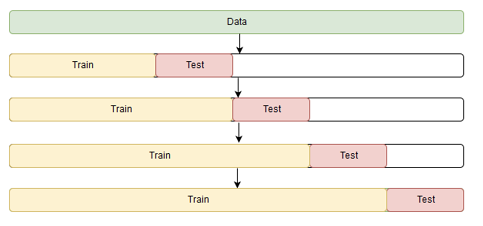

This decision affects the research, so another step could be to check the results with different split by the function - train_test_split or use pandas dataframe sampling the data for different days. For the scaling of the data is used the MinMaxScaler. Another possible algorithm is RobustScaler which is reducing the effect of outliers.

In [0]:
london_df = london.drop(['timestamp','cnt'],axis=1)
X = london_df.drop(['count_log'], axis=1)
y = london_df['count_log']
scaler_x = preprocessing.MinMaxScaler()
X =  pd.DataFrame(scaler_x.fit_transform(X), columns = X.columns)

In [0]:
def df_split(df,train_percent):
    """
    Function to split DataFrame/Series on percentage value.
    Input:
    -------
    -df - pandas DataFrame
    -train_percent - the percentage /100 of the data that we want to split. value between [0,1]
    
    Output:
    --------
    -two pandas DataFrames
    """
    assert_is_not_none(df)
    assert_greater(train_percent,0)
    assert_less(train_percent,1)
    
    split_index = int(train_percent * len(df))
    train = df.iloc[:split_index]
    test = df.iloc[split_index:]
    return train,test

In [0]:
X_train,X_test = df_split(X,0.7)
y_train,y_test = df_split(y,0.7)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
X_test.shape

In [ ]:
y_test.shape

In [ ]:
london.shape

In [ ]:
sns_hist(pd.DataFrame(y_train),"Histogram of logarithm transformed count of bike shares train set")

In [ ]:
sns_hist(pd.DataFrame(y_test),"Histogram of logarithm transformed count of bike shares test set")
#sns.distplot(pd.DataFrame(y_test), fit=norm)
#plt.title("Histogram of logarithm transformed count of bike shares test set")
#plt.ylabel('Density')

## 3.2.Choosing a scoring metric
A custom scoring function is implemented - *Root mean squared logarithmic error* -  ***RMSLE***. The built-in function *mean_squared_log_error* can not handle negative values, also the linear regression can return very high values. The new custom function is replacing the negative values with 0 and highly positive values with 10. Prediction of 10 after transforming back e<sup>10</sup>=22026 shared bikes, which is far above the dataset maximum of 8000. The evaluation metric of RMSLE is chosen because the dataset contains very large and very small values [5]. With this metric the outlier will have smaller effects during the scoring and predictions are evaluated with percentage error. Another effect of this metric is that it is adding extra penalty to underestimates - see the graphic below, from [5].


<img src=" 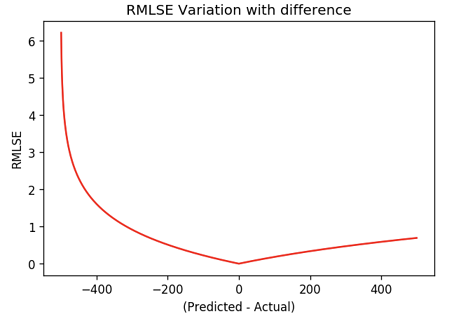" width="448">

In [0]:
def rmsle(y, y_pred):
    """
    Root squared logarithmic loss function.
    The function is trimming the negative values and replace them with 0. After that calculates the RMSLE.
    Input:
    y - true values
    y_pred - predicted values

    Output: RMSLE
    """
    assert(y.shape == y_pred.shape)
    y = np.expm1(y)
    y_pred=y_pred.clip(min=0)
    y_pred=y_pred.clip(max=10)
    y_pred = np.expm1(y_pred)
    return np.sqrt(mean_squared_log_error( y, y_pred))


rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=5)

In [0]:
columns = ['weather_code','season','is_non_workday']
X_dummies = pd.get_dummies(X_train, columns=columns)
X_dummies = X_dummies.drop(['day','year','month'],axis=1)


Please wait 1 minute for the performance tests, if you want to speed it up, just remove SVR() from **regressors** variable and the 4<sup>th</sup> element of **data_X** variable.

In [ ]:
def test_algorithms():
    
    """
    A custom function designed for cross validation score on "london bike sharing dataset".
    The function is comparing the following algorithms :
    "LinearRegression", "Random Forrest", "XGBoost", "SVR" , "AdaBoost","BaggingRegressor",
    on "London bicycle sharing dataset" with mean RMSLE error, standard deviation on RMSLE and execution time. 
    The output of this function is a pandas dataframe.
    """
    names = ["LinearRegression", "Random Forrest", "XGBoost", "SVR" , "AdaBoost",
             "BaggingRegressor"]
    
    regressors = [
        LinearRegression(),
        RandomForestRegressor(random_state=42),
        XGBRegressor(objective ='reg:squarederror',random_state=42),
        SVR(),
        AdaBoostRegressor(random_state=42),
        BaggingRegressor(random_state=42)    
        ]
    
    data_X = [X_dummies,X_train ,X_train ,X_dummies ,X_train ,X_train ]
    reg_columns=['algorithm','score_rmsle_mean','score_std','time']
    reg_performance = pd.DataFrame(columns=reg_columns)
    print('Please wait 1-2 minutes for all algorithms to complete.')
    for name, regressor, X_trains in zip(names, regressors,data_X):
        time_start = time.time()
        cv_results = cross_val_score(regressor, X_trains,y_train, cv=5 ,scoring = rmsle_scorer)
        time_end = round(time.time() - time_start,3)
        mean_score = round(-cv_results.mean(),4)
        std_score = round(cv_results.std(),4)
        t= pd.DataFrame([[name,mean_score,std_score,time_end]],columns = reg_columns)
        reg_performance = reg_performance.append(t, ignore_index=True)
        print(name , ' RMSLE = ',mean_score , 'with std=',std_score ," execution_time =  ", time_end,"s")
    return reg_performance
reg_performance = test_algorithms()
reg_performance

In [ ]:
def plot_performance(df,x,y):
    """
    Function to bar plot algorithm performance.
    Inputs
    -------
    - df: DataFrame generated by test_algorithms() function
    - x: x column name, usually 'algorithm'
    - y: y column name - 'score_rmsle_mean' or 'time'
    
    Returns
    -------
    Barplot of the performance
    """
    assert_is_not_none(df)
    assert_true(x in set(df.columns))
    assert_true(y in set(df.columns))
    
    
    sns.barplot(data=df, x=x,y=y)
    plt.title('Performance of different algorithms')
    plt.xticks( rotation='vertical')


plot_performance(reg_performance, x='algorithm',y='score_rmsle_mean')


## 3.3.Cross validation
The results from the graphic above shows that *Random Forrest, XGBoost* and *Bagging Regressor* are the top 3 algorithms that are performing well with the default settings. During this research they are tuned and evaluated with the testing set. The code requires 10-20 minutes to perform a GridSearchCV on these 3 algorithms. To save time of future use of the algorithms, the best estimators are exported with "pickle" to a single file. The files are uploaded on "Dropbox" and the links are saved below.
For the splitting of the data is used TimeSeriesSplit, another solution is to try kfolds split.

In [0]:
#################CAUTION LONG_RUNNING_CODE#####################################

"""
The following code is used to optimize 3 machine learning algorithms and export
the trained models to a pickle file. Uncomment if needed to check the results.

"""


def save_pickle(model):
    """
    Export sklearn trained model to a file.
    Input:
    ----------
    - model:sklearn trained model
    """
    pickle.dump(model, open(model.__class__.__name__ + '.model', 'wb'))
    print('Model saved as ' + model.__class__.__name__ + '.model')

###############################################################################
############################XGBoost############################################
#grid_values = {'learning_rate': [0.001, 0.01, 0.1, 0.3],
#               'n_estimators':[100,700,1000,1200],
#               'max_depth': [3,5,8,10],
#               #'min_child_weight': [1,2,3,4],
#               #'gamma':[0, 0.1, 0.2, 0.3]
#               #'reg_alpha': [0.1,1,200,500],#L1
#               #'reg_lambda':[1,200,500],#L2
#               }
#
#
#
#grid_xgb = GridSearchCV(XGBRegressor(objective = 'reg:squarederror',early_stopping_rounds=20, eval_metric="rmse",random_state=42),
#                        n_jobs=-1, param_grid = grid_values,cv=tscv,scoring = rmsle_scorer)
#grid_xgb.fit(X_train, y_train)
#save_pickle(grid_xgb.best_estimator_)
#pd.DataFrame(grid_xgb.cv_results_).to_csv('XGB_cv_results.csv')
##############################################################################
######################RandomForrest###########################################
#
#grid_values_rf = {'n_estimators': [10,100,500,750,1000,1200],
#                  'max_depth' : [5,7,8,9],
#                  'min_samples_leaf': [5,10,25,50],
#                #'max_features': ['auto', 'sqrt'],
#                }
#
#grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid = grid_values_rf,cv=tscv,scoring = rmsle_scorer)
#grid_rf.fit(X_train, y_train)
#save_pickle(grid_rf.best_estimator_)
#pd.DataFrame(grid_rf.cv_results_).to_csv('RF_cs_results.csv')
################################################################################
########################BaggringRegressor#######################################
#grid_values_br = {'n_estimators':[10,100,500,1000]}
#
#grid_br = GridSearchCV(BaggingRegressor(random_state=42) , param_grid = grid_values_br,cv=tscv,scoring = rmsle_scorer)
#grid_br.fit(X_train, y_train)
#
##################save_pickle(grid_br.best_estimator_)#####skipped due very long size on disk
#pd.DataFrame(grid_br.cv_results_).to_csv('BR_cv_results.csv')
################################################################################
################################################################################

In [0]:
#!cp 'XGBRegressor.model' 'drive/My Drive/XGBRegressor.model'
#!cp 'XGB_cv_results.csv' 'drive/My Drive/XGB_cv_results.csv'

#!cp 'RandomForestRegressor.model' 'drive/My Drive/RandomForestRegressor.model'
#!cp 'RF_cs_results.csv' 'drive/My Drive/RF_cs_results.csv'

In [0]:
def load_pickle(url):
    """
    Funtion to load existing trained model, previously saved by pickle.
    Inputs
    -------
    - url: DataFrame generated by test_algorithms() function
    
    Returns
    -------
    - sklearn trained model
    
    """
    try:
        loaded_model = pickle.load(urlopen(url))
        print('Model loaded.')
        return loaded_model
    except:
        print('Unable to load the model from url.')
        return 0

The BaggringRegressor is excluded from the saved models, because of very long size on disk after tuning. With '*n_estimators*' = 1000 the size on disk is **930 MB**. With the default '*n_estimators*' = 10, the size on disk is approximately 9MB, but the RMSLE will be higher that the tuned algorithms. This algorithm achieved on **testing set** RMSLE = 0.26813.

In [0]:
xgb_model_url = 'https://www.dropbox.com/s/zihko63rehvmpb6/XGBRegressor.model?dl=1'
rf_model_url = 'https://www.dropbox.com/s/9o62bwl4d8zmqx8/RandomForestRegressor.model?dl=1'


xgb_results_url = 'https://www.dropbox.com/s/tb7125oq2g5fqt4/XGB_cv_results.csv?dl=1'
rf_results_url = 'https://www.dropbox.com/s/dluxmpewpu3fen7/RF_cs_results.csv?dl=1'


br_results_url = 'https://www.dropbox.com/s/hkeselt1tbnsgx0/BR_cv_results.csv?dl=1'

In [ ]:
xgb_tuned = load_pickle(xgb_model_url)
assert_is_not_none(xgb_tuned)
rf_tuned = load_pickle(rf_model_url)
assert_is_not_none(rf_tuned)

The "cv_results" from the GridSearchCV are also exported and the code below shows the top 3 hyperparameter combinations, their RMSLE score and training time of every algorithm.

In [0]:
xgb_cv = pd.read_csv(xgb_results_url)
rf_cv = pd.read_csv(rf_results_url)
br_cv = pd.read_csv(br_results_url)

assert_is_not_none(xgb_cv)
assert_is_not_none(rf_cv)
assert_is_not_none(br_cv)


In [ ]:
xgb_cv[xgb_cv['rank_test_score']<4]

In [ ]:
rf_cv[rf_cv['rank_test_score']<4]

In [ ]:
br_cv[br_cv['rank_test_score']<4]

In [ ]:
def convert_df(df,name):
    """
    Function to convert the cv_result DataFrame for plotting.
    
    Inputs
    -------
    - df: DataFrame generated by GridSearchCV
    - name: name of the algorithm tuned with GridSearchCV
    
    Returns
    -------
    - converted DataFrame suitable for barplot
    """
    assert_is_not_none(df)
    assert_is_instance(df, pd.DataFrame)
    test_set = set(['rank_test_score','split0_test_score','split1_test_score','split2_test_score',
                   'split3_test_score','split4_test_score'])
    assert_true(test_set.issubset(set(df.columns)))

    
    t = df[df['rank_test_score']==1][['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score']]
    t = -t.T
    t=t.reset_index()
    t.columns=['algorithm','RMSLE_score']
    t.algorithm = name
    return t
clean = convert_df(xgb_cv,'XGBoost')
clean = clean.append(convert_df(rf_cv,'RandomForest'))
clean = clean.append(convert_df(br_cv,'BaggingRegressor'))
clean

The results of cross validation shows that XGBoost have the smallest RMSLE error min rmlse=0.22 and max rmsle=0.34. The next steps are feature importance analysis, to test the algorithms on the testing set and residuals analysis of XGBoost and Random Forrest. A code block from [21] is used for the feature importance graphics.

In [ ]:
plot_performance(clean, x='algorithm',y='RMSLE_score')

## 3.4.Feature importance

In [ ]:
def plot_importance(model):
    """
    Fuction to plot variable importance from machine learning model.
    Note: the model requires to have "model.feature_importances_".
    
    Inputs
    -------
    - model: a model with a object ".feature_importances_"

    Returns
    -------
    - feature importance plot
    

    """
    assert_is_not_none(model.feature_importances_)

    feature_importance = model.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title(f'Variable Importance {model.__class__.__name__}')
    plt.show()

plot_importance(xgb_tuned)
plot_importance(rf_tuned)

## 3.5.Scoring on the testing set.

In [0]:
def plot_scores(model,X_train,y_train):
    """
    Functon to plot scores RMSE, MAE, R^2, RMSLE from model.
    
    Inputs
    -------
    - model: a trained model
    - X_train: X_train or X_test DataFrame/Series
    - y_train: y_train or y_test DataFrame/Series
    
    
    """

    assert(y_train.shape[0] == X_train.shape[0])
    
    print("Model parameters ", model.__class__.__name__)
    prediction_train = np.expm1((model.predict(X_train).clip(min=0)))
    y_train = np.expm1(y_train)
    print("Root Mean Squared Error: " + str(np.sqrt(mean_squared_error(y_train, prediction_train))))
    print("Mean Absolute Error: " + str(mean_absolute_error(y_train, prediction_train)))
    print("R^2 Coefficient of Determination: " + str(r2_score(y_train, prediction_train)))
    print('RMSLE:', np.sqrt(mean_squared_log_error(y_train, prediction_train)))
    

In [ ]:
plot_scores(xgb_tuned,X_test,y_test)

In [ ]:
plot_scores(rf_tuned,X_test,y_test)

The XGBoost is performing better compared to the Random Forest,another possible optimization is to take the mean of the 2 algorithms. 

In [ ]:
algo_xgb = xgb_tuned.predict(X_test)
algo_rf = rf_tuned.predict(X_test)
mean =  (np.expm1(algo_xgb) + np.expm1(algo_rf))/2
mean_log = np.log1p(mean)
print("RMSLE of combined XGBoost and Random Forrest = ",rmsle(y_test,mean_log))

## 3.6.Analysing residuals

There are different methods to perform a normal distribution test [19]. Some of them are Shapiro-Wilk Test, D’Agostino’s K^2 Test, Anderson-Darling Test. The Shapiro-Wilk Test requires the maximum size of the distribution to be less than 5000. The testing set is slightly bigger that this value, so for the research is performed D’Agostino’s K^2 Test.  
For further analysis 3 plots are created - scatter plot, histogram and Q-Q plot of the residuals.

In [ ]:

def residual_plot(y_test, y_predicted,main_title):
    """
    Function to plot the residual distribution calculated from y_test and y_predicted.
    
    Inputs
    -------
    - y_test: the log transformed target values
    - y_predicted: raw predictions from the algorithm
    - main_title: main title of the plot
    
    Returns
    -------
    - a plot containing 3 subplots: Scatter plot, Histogram and Q-Q plot
    
    
    """
    res =  np.expm1(y_test) - np.expm1(y_predicted)
    fig, axs = plt.subplots(1,3, figsize=(25, 5))
    ##D’Agostino’s K^2 Test
    stat, p = stats.normaltest(res)
    print("Performing a D’Agostino’s K^2 Test for a normal distribution of residuals.")
    print("H0 = The distribution is Gaussian.P value to reject H0 is p= 0.05 = 5%")
    print('Statistics=%.3f, p=%.5f' % (stat, p))
    # interpretation of the test
    alpha = 0.05
    if p > alpha:
        print("failed to reject H0 (H0 = The distribution is Gaussian).Can't accept any hypothesis. ")
    else:
        print('The distribution does not look Gaussian (H0 is rejected)')
    #End of D’Agostino’s K^2 Test
    #Begin of plotting
    plt.suptitle(f'{main_title} ; mean_residual =  {res.mean():.1f}, std= {res.std():.1f},  skew =  {res.skew():.4f} , kurtosis= {res.kurtosis():.2f}'  )
    axs[0].title.set_text('Scatter Plot y_test vs residuals(true-predicted)')
    axs[0].scatter(np.expm1(y_test),res)
    axs[1].title.set_text('Histogram of residuals')
    sns.distplot(res, fit=norm, ax = axs[1]);
    axs[2].title.set_text('Q-Q plot')
    sm.qqplot(res, stats.t, distargs=(4,),line = 's', ax=axs[2])
    plt.show()

residual_plot(y_test, xgb_tuned.predict(X_test) ,"Residual plots of XGBoost predictions")
residual_plot(y_test, rf_tuned.predict(X_test) ,"Residual plots of RandomForrest predictions")



There are some outliers that are visible in the scatter plot and histogram, but most of the quantity of residuals are near 0. The shape of residuals on the scatter plot is affected by the RMSLE metric. Underestimates have greater penalty than overestimates and the scoring is performed on percentage error - huge difference on high value predictions are not so much penalized. This metric reduces the effect of errors generated by outliers in dataset.
The residuals of both models 'XGBoost' and 'Random Forest' are not normally distributed(Gaussian). The **H<sub>0</sub>** - *'The distribution is Gaussian'* is rejected with the D’Agostino’s K^2 Test with P value = 0.0000. On both models residual's mean is positive and close to 0. 

>"*A distribution with kurtosis >3 (excess kurtosis >0) is called **leptokurtic**. Compared to a normal distribution, its tails are longer and fatter, and often its central peak is higher and sharper.*" - [17]

>"*In general, leptokurtic distributions have heavier tails or a higher probability of extreme outlier values when compared to mesokurtic or platykurtic distributions.*" - [18]  

> "*Quantile plots : This type of is to assess whether the distribution of the residual is normal or not. The graph is between the actual distribution of residual quantiles and a perfectly normal distribution residuals. If the graph is perfectly overlaying on the diagonal, the residual is normally distributed. *"-[28]  

In the Q-Q plot the actual distribution of residuals are not well fitted to the theoretical quantiles(the red line), also the residuals are in between [-11σ ;11σ] which is very big interval for a normal distribution.   
The Random forest residuals have positive skew and positive mean. Also with increasing of the predicting variable the residuals also increase, but only in positive direction. The variance of the residuals is increasing and there is a positive systematic error with increasing of the predicted variable.  
The residuals of XGBoost looks better in this terms, still there are outliers, but the mean of the residuals is closer to zero, Q-Q plot is better fitted than Random Forest.

## 3.7.Performance evaluation

With the XGBoost the best achieved RMSLE score is 0.2611, converted to a standard deviation is e<sup>0.2611</sup> is 1.30. So the upper and lower boundary of probability interval, calculated with ±1standart deviation are 1.30 times greater and lesser than the actual prediction (similar example in [31] - page637). If we take the average of transformed predictions of both algorithms the RMLSE score is 0.2557. Converted this to a standard deviation is e<sup>0.2557</sup> is 1.29 times of a prediction.  
The XGBoost have overfitting problems, even overfits on test set, when the predictions on the both sets are good, but on production have poor performance.

In [ ]:
print('---------Model evaluation on train set---------------')
plot_scores(xgb_tuned,X_train,y_train)
print('\n--------Model evaluation on test set---------------')
plot_scores(xgb_tuned,X_test,y_test)

print('\n---------Model evaluation on train set---------------')
plot_scores(rf_tuned,X_train,y_train)
print('\n--------Model evaluation on test set---------------')
plot_scores(rf_tuned,X_test,y_test)

In [ ]:
target_rmsle = np.log(1.25)
target_rmsle

If we accept a target(base) error for our predictions of 25% and convert this to RMSLE score = 0.2231.

<table class="tg">
  <tr>
    <th class="tg-0lax"></th>
    <th class="tg-0lax">algorithm</th>
    <th class="tg-0pky">RMSLE score</th>
    <th class="tg-dvpl">difference in RMSLE(test-train score)<br></th>
  </tr>
  <tr>
    <td class="tg-0lax">train</td>
    <td class="tg-0lax">XGboost</td>
    <td class="tg-0pky">0.1877</td>
    <td class="tg-0pky" rowspan="2">0.0734</td>
  </tr>
  <tr>
    <td class="tg-0lax">test</td>
    <td class="tg-0lax">XGboost</td>
    <td class="tg-0pky">0.2611</td>
  </tr>
  <tr>
    <td class="tg-0lax">train</td>
    <td class="tg-0lax">Random Forest</td>
    <td class="tg-0pky">0.2221</td>
    <td class="tg-0pky" rowspan="2">0.0586</td>
  </tr>
  <tr>
    <td class="tg-0lax">test</td>
    <td class="tg-0lax">Random Forest</td>
    <td class="tg-0pky">0.2807</td>
  </tr>
</table>

Both algorithms performed great on the train set - low bias. The difference between train and test set scores shows high variance.

## **Conclusion**:  
The tuned algorithms (XGBoost and Random Forest) suffer from high variance. The next possible steps are to try to reduce this affect: adding more data and increase the effect of the regularization. The bike shares during the winter are less than the rest of the year. The algorithm is trained on year and a half training data and validated on half year test set. Maybe adding more data during the winter will help of the performance during this period or use oversampling. The models that could be tied also for this dataset are ARIMA, SARIMA, Prophet.

## References:  
[1] London bike sharing dataset - https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset  
[2] Source of London bike usage - https://tfl.gov.uk/info-for/open-data-users/our-open-data#on-this-page-5  
[3] MSLE - https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/mean-squared-logarithmic-error  
[4] MAE; R^2; RMSLE - https://hrngok.github.io/posts/metrics/  
[5] RMSE vs RMSLE - https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a  
[6] Choosing an evaluation metric - https://towardsdatascience.com/how-to-select-the-right-evaluation-metric-for-machine-learning-models-part-1-regrression-metrics-3606e25beae0  
[7] Deal with highly skewed data - https://becominghuman.ai/how-to-deal-with-skewed-dataset-in-machine-learning-afd2928011cc  
[8] Common variance stabilizing transformations  - https://stats.stackexchange.com/questions/18844/when-and-why-should-you-take-the-log-of-a-distribution-of-numbers/18852  
[9] London bike sharing data exploration - https://medium.com/@AJOhrn/data-footprint-of-bike-sharing-in-london-be9e11425248  
[10] Bike sharing kaggle competition - https://www.kaggle.com/c/bike-sharing-demand  
[11] One-hot encoder on ensemble models - https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769  
[12] TimeSeriesSplit - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html  
[13] TimeSeries nested cross validation - https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9  
[14] Avoiding data leakage in ML - https://conlanscientific.com/posts/category/blog/post/avoiding-data-leakage-machine-learning/  
[15] Random Forest tuning - https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74  
[16] Bike sharing map - https://bikesharemap.com/london/#/12/-0.0691/51.4535/  
[17] Skewness and kurtosis - https://brownmath.com/stat/shape.htm  
[18] Leptokurtic distribution - https://www.investopedia.com/terms/l/leptokurtic.asp  
[19] Normality test in python - QQ plot; Shapiro-Wilk Test;D’Agostino’s K^2 Test; Anderson-Darling Test; - https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/  
[20] Q-Q plot and normality tests Medium article - https://medium.com/@rrfd/testing-for-normality-applications-with-python-6bf06ed646a9  
[21] Feature importance in ensemble models - https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html  
[22] Comparing Regression models - https://www.kaggle.com/ankitjha/comparing-regression-models  
[23] QQPLot interpretation - https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot/101290#101290  
[24] QQPlot - Spring 2016 - https://math.illinois.edu/system/files/inline-files/Proj9AY1516-report2.pdf  
[25] https://medium.com/data-distilled/residual-plots-part-2-normal-qq-plots-c220ee9ed9fc  
[26] Create a diagnostic plots - https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/  
[27] Interpreting residual plots to improve regression - http://docs.statwing.com/interpreting-residual-plots-to-improve-your-regression/#transform  
[28] Diagnose residual plots in regression - https://www.analyticsvidhya.com/blog/2013/12/residual-plots-regression-model/  
[29] How to check the quality of regression model - https://towardsdatascience.com/how-do-you-check-the-quality-of-your-regression-model-in-python-fa61759ff685  
[30] Optimize RMSLE in XGBoost - https://www.kaggle.com/c/grupo-bimbo-inventory-demand/discussion/22759  
[31] RMSLE interpretation - https://books.google.bg/books?id=WaZ-DwAAQBAJ&pg=PA637&lpg=PA637&dq=rmsle+score+meaning&source=bl&ots=RuzEardmbM&sig=ACfU3U0sokwpzgXKPBjRSGEY6oORYwvsbQ&hl=en&sa=X&ved=2ahUKEwiklMiSo7TlAhXRoFwKHR-jCXcQ6AEwE3oECAkQAg#v=onepage&q=rmsle%20score%20meaning&f=false  
[32] XGBoost docs - https://xgboost.readthedocs.io/en/latest/parameter.html  
[33] XGBoost tuning - http://www.fantasyfutopia.com/python-for-fantasy-football-random-forest-and-xgboost-hyperparameter-tuning/